In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import re
import seaborn as sns
import numpy as np

In [4]:
from folders_paths import *
print(folder_paths)

['/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/100k_iter/w5', '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/100k_iter/w10', '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/100k_iter/w20', '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/100k_iter/w25', '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/100k_iter/w50', '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/100k_iter/w100']


### Create functions to calculate biodiversity among random pairs in each file.
- The first function will calculate average genetic diversity in the file.
- The second function will produce a table with individual diversity counts for each random pair.


The number of random pairs is given by the number of individual in the sample / 2 

In [5]:
# Creating a function to calculate genetic diversity among pairs
# I will use this one to calculate the average diversity of the sample
def average_diversity_simulation(genomes, num_pairs):
    # Select random pairs of indices
    random_indices = random.sample(range(len(genomes)), 2 * num_pairs)

    # Initialize a counter for differences
    differences_count = 0

    # Compare strings in random pairs
    for i in range(0, len(random_indices), 2):
        index1, index2 = random_indices[i], random_indices[i + 1]
        string1, string2 = genomes.iloc[index1], genomes.iloc[index2]

        # Compare strings and count differences
        differences_count = differences_count + sum(c1 != c2 for c1, c2 in zip(string1, string2))

    # Calculate the average differences per pair
    average_differences = differences_count / num_pairs

    return average_differences

# Creating a function to create and store diversity values and return them in a table, 
# from this table we will calculate stats for each sample
def diversity_table(genomes, num_pairs):
    # Select random pairs of indices
    random_indices = random.sample(range(len(genomes)), 2 * num_pairs)

    # Initialize a counter for differences
    differences_list = []

    # Compare strings in random pairs
    for i in range(0, len(random_indices), 2):
        index1, index2 = random_indices[i], random_indices[i + 1]
        string1, string2 = genomes.iloc[index1], genomes.iloc[index2]

        # Compare strings and count differences
        differences_count = sum(c1 != c2 for c1, c2 in zip(string1, string2))

        # Append to the list
        differences_list.append((differences_count))

    return differences_list


### Median Diversity - individual simulations
Create plots with median diversity at equilibrium for each simulation

In [6]:
# Create a list to store individual DataFrames
dataframes = []

for i, folder_path in enumerate(folder_paths):
    # Create a list to store all the DataFrames for the current folder
    dfs = []
    
    # Loop through each file in the folder and read it into a DataFrame
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_individuals_data_.*\.txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)

            # Read the DataFrame from the file
            df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
            genomes = df['Genome']
            # keep the first 32 bits from each genome
            #genomes = df['Genome'].str[:32]
            #remove the first 32 and keep the last
            #genomes = df['Genome'].str[32:]
            
            # Calculate genetic diversity and store in the list
            diversity_list = diversity_table(genomes, len(genomes) // 2)

            # Create a DataFrame with an additional 'File' column
            div_df = pd.DataFrame({'Diversity': diversity_list, 'Environment': folder_labels[i], 'Simulation': filename})
            dfs.append(div_df)

    # Concatenate all DataFrames in the list
    combined_df_folder = pd.concat(dfs, ignore_index=True)
    dataframes.append(combined_df_folder)

# Concatenate all DataFrames from different folders into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Calculate median diversity for each simulation
median_diversity = combined_df.groupby('Simulation')['Diversity'].median().sort_values()

# Create a plot and a table to show average diversity 
# Create grid
grid = sns.FacetGrid(combined_df, col='Environment', palette='viridis', col_wrap=2, height=4, aspect=1.5, sharey=True)
# grid.map_dataframe(sns.violinplot, x='Simulation', y='Diversity', order=median_diversity.index, cut=0)
grid.map_dataframe(sns.boxplot, x='Simulation', y='Diversity', order=median_diversity.index, flierprops=dict(markersize=0))
grid.set_titles(col_template='Env w = {col_name}')

# Remove x-axis labels
for ax in grid.axes.flat:
    ax.set(xticklabels=[])
    
# Adjust the arrangement of the plots
grid.tight_layout(w_pad=1)

# Show the plot
plt.show()

In [7]:
# Let's create a table with average diversity for each simulation
average_div_df = combined_df.groupby(['Environment','Simulation'])['Diversity'].mean().reset_index()

Text(0.5, 1.0, 'Mean Genetic Diversity at Equilibrium')

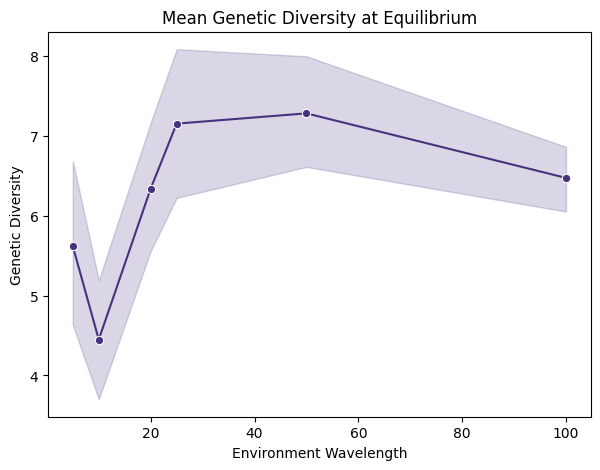

In [8]:
### Now I'm creating a graph that will show the wavelength on the xaxis and the average/median SP that we had at equilibrium
grouped_df = combined_df.groupby('Environment')
num_environments = len(grouped_df)
colors = sns.color_palette("viridis", num_environments)

plt.figure(figsize=(7, 5))
sns.lineplot(data =  average_div_df, x = 'Environment', y = 'Diversity', color = colors[0], marker='o')
plt.xlabel('Environment Wavelength')
plt.ylabel('Genetic Diversity')
plt.title('Mean Genetic Diversity at Equilibrium')

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_33372/2224160231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Environment', y='Diversity', data=average_div_df, palette='colorblind', alpha=0.7, cut=0, inner="quartile")


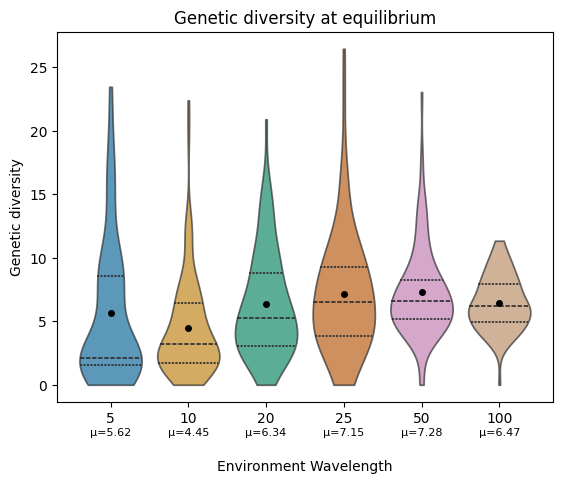

In [9]:
# create a seaborn violin plot
# Create a boxplot
ax = sns.violinplot(x='Environment', y='Diversity', data=average_div_df, palette='colorblind', alpha=0.7, cut=0, inner="quartile")

# Add mean points
ws = average_div_df['Environment'].unique()  # Get unique categories in sorted order

for i, w in enumerate(ws):
    # Calculate median and mean
    median_val = average_div_df[average_div_df['Environment'] == w]['Diversity'].median()
    mean_val = average_div_df[average_div_df['Environment'] == w]['Diversity'].mean()
    ax.plot(i, mean_val, 'o', color="black", markersize=4, zorder=3)  # Plot mean point

    # Annotate the mean value using the μ symbol
    ax.text(i, -3.8, f'μ={mean_val:.2f}', verticalalignment='center', horizontalalignment='center', fontsize=8, color='black')

# Labels
plt.xlabel("Environment Wavelength", labelpad=25)
plt.ylabel('Genetic diversity')
plt.title('Genetic diversity at equilibrium')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


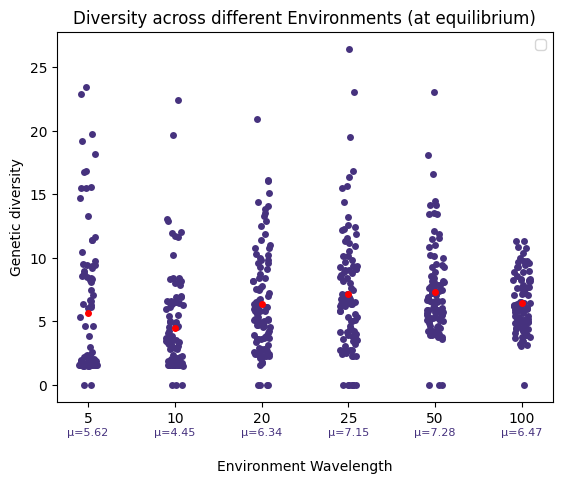

In [10]:
# Same data but different graphs: Jitter plot
ax = sns.stripplot(data=average_div_df, x='Environment', y='Diversity', jitter=True, color=colors[0])

# Add mean points
ws = average_div_df['Environment'].unique()  # Get unique categories in sorted order

for i, w in enumerate(ws):
    # Calculate median and mean
    median_val = average_div_df[average_div_df['Environment'] == w]['Diversity'].median()
    mean_val = average_div_df[average_div_df['Environment'] == w]['Diversity'].mean()
    ax.plot(i, mean_val, 'o', color="red", markersize=4, zorder=3)  # Plot mean point

    # Annotate the mean value using the μ symbol
    ax.text(i, -3.8, f'μ={mean_val:.2f}', verticalalignment='center', horizontalalignment='center', fontsize=8, color=colors[0])

# Labels and title
plt.xlabel("Environment Wavelength", labelpad=25)
plt.ylabel("Genetic diversity")
plt.title('Diversity across different Environments (at equilibrium)')
plt.legend()
plt.show()


### Species Richness VS Genetic Diversity


In [11]:
### Creating a table that for each simulation it has average genetic diversity and average species richness
# importing from log files

# Create a list to store individual DataFrames
dataframes = []

for i, folder_path in enumerate(folder_paths):
    # Loop through each file in the folder and read it into a DataFrame
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_log_.*\.txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)
            #df = pd.read_csv(file_path, sep=',', header=0, usecols=[0, 5], names=['Iteration_number', 'Species_count'])
            
            df = pd.read_csv(file_path, sep=',', header=0, usecols=[0, 5])
            
            # Remove duplicates
            df = df.drop_duplicates()
            
            # Add 'simulation' and 'folder_label' columns
            df['Simulation'] = filename
            df['Environment'] = folder_labels[i]
            
            # Only keeping the data about equilibrium
            df = df[df['Iteration_Number'] == 99999]
            
            # Append the modified DataFrame to the list
            dataframes.append(df)

# Concatenate all data in a pandas dataframe
logs_df = pd.concat(dataframes, ignore_index=True)


In [12]:
# checking the length of logs_df and average_div_df, they should have the same number of simulations. 
print(len(logs_df))
print(len(average_div_df))

print(logs_df.head())
print(average_div_df.head())

580
600
   Iteration_Number  Species_Count                        Simulation  \
0             99999              1   REvoSim_log_envw5_15dp_aj29.txt   
1             99999            939   REvoSim_log_envw5_15dp_aj15.txt   
2             99999            512   REvoSim_log_envw5_15dp_aj14.txt   
3             99999            243   REvoSim_log_envw5_15dp_aj28.txt   
4             99999              1  REvoSim_log_envw5_15dp_aj100.txt   

   Environment  
0            5  
1            5  
2            5  
3            5  
4            5  
   Environment                                     Simulation  Diversity
0            5    REvoSim_individuals_data_envw5_15dp_aj1.txt   9.516552
1            5   REvoSim_individuals_data_envw5_15dp_aj10.txt   1.625566
2            5  REvoSim_individuals_data_envw5_15dp_aj100.txt   1.520872
3            5   REvoSim_individuals_data_envw5_15dp_aj11.txt  23.459809
4            5   REvoSim_individuals_data_envw5_15dp_aj12.txt   2.338850


In [13]:
# Extracting numbers from filenames and storing in a new column
logs_df['Simulation_Number'] = logs_df['Simulation'].apply(lambda x: int(re.findall(r'\d+', x.split('_')[-1])[0]))
average_div_df['Simulation_Number'] = average_div_df['Simulation'].apply(lambda x: int(re.findall(r'\d+', x.split('_')[-1])[0]))
print(logs_df.head())
print(average_div_df.head())

   Iteration_Number  Species_Count                        Simulation  \
0             99999              1   REvoSim_log_envw5_15dp_aj29.txt   
1             99999            939   REvoSim_log_envw5_15dp_aj15.txt   
2             99999            512   REvoSim_log_envw5_15dp_aj14.txt   
3             99999            243   REvoSim_log_envw5_15dp_aj28.txt   
4             99999              1  REvoSim_log_envw5_15dp_aj100.txt   

   Environment  Simulation_Number  
0            5                 29  
1            5                 15  
2            5                 14  
3            5                 28  
4            5                100  
   Environment                                     Simulation  Diversity  \
0            5    REvoSim_individuals_data_envw5_15dp_aj1.txt   9.516552   
1            5   REvoSim_individuals_data_envw5_15dp_aj10.txt   1.625566   
2            5  REvoSim_individuals_data_envw5_15dp_aj100.txt   1.520872   
3            5   REvoSim_individuals_data_envw5

In [14]:
# Merging the dataframes
merged_df = pd.merge(logs_df, average_div_df, on=['Simulation_Number', 'Environment'])
print(merged_df)

     Iteration_Number  Species_Count                       Simulation_x  \
0               99999              1    REvoSim_log_envw5_15dp_aj29.txt   
1               99999            939    REvoSim_log_envw5_15dp_aj15.txt   
2               99999            512    REvoSim_log_envw5_15dp_aj14.txt   
3               99999            243    REvoSim_log_envw5_15dp_aj28.txt   
4               99999              1   REvoSim_log_envw5_15dp_aj100.txt   
..                ...            ...                                ...   
575             99999              1  REvoSim_log_envw100_15dp_aj11.txt   
576             99999              3   REvoSim_log_envw100_15dp_aj2.txt   
577             99999              1   REvoSim_log_envw100_15dp_aj3.txt   
578             99999              1  REvoSim_log_envw100_15dp_aj10.txt   
579             99999              1  REvoSim_log_envw100_15dp_aj38.txt   

     Environment  Simulation_Number  \
0              5                 29   
1              5     

Text(0.5, 1.05, 'Genetic Diversity vs Species Richness at Equilibrium')

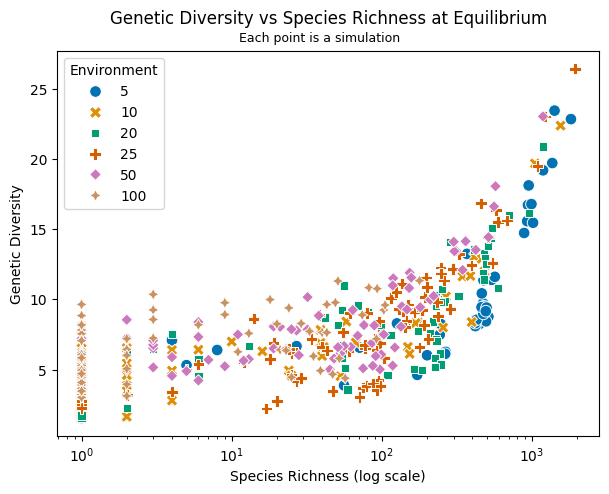

In [15]:
# Create a scatter plot
plt.figure(figsize=(7, 5))
sns.scatterplot(data=merged_df, y='Diversity', x='Species_Count', hue='Environment', style='Environment', palette='colorblind', s = 70)
plt.xlabel('Species Richness (log scale)')
plt.ylabel('Genetic Diversity')
plt.xscale('log')
plt.suptitle('Each point is a simulation', fontsize=9, y=0.92)
plt.title('Genetic Diversity vs Species Richness at Equilibrium', y=1.05)


Text(0.5, 1.05, 'Genetic Diversity vs Species Richness at Equilibrium')

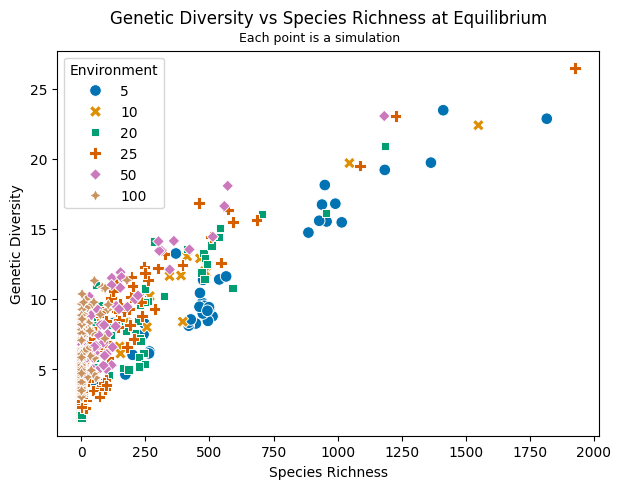

In [16]:
# Create a scatter plot
plt.figure(figsize=(7, 5))
sns.scatterplot(data=merged_df, y='Diversity', x='Species_Count', hue='Environment', style='Environment', palette='colorblind', s = 70)
plt.xlabel('Species Richness')
plt.ylabel('Genetic Diversity')
plt.suptitle('Each point is a simulation', fontsize=9, y=0.92)
plt.title('Genetic Diversity vs Species Richness at Equilibrium', y=1.05)



## Ideal  number of pairs
It is computationally intensive to calculate the diversity for all pairs in the sample, so I'm goign to see after how many pairs we have a stabilisation of the estimate of diversity.

In [ ]:
# Loop through each folder
for folder_path, folder_label in zip(folder_paths, folder_labels):

    # Initialize lists to store accumulated diversity lists for each file
    all_diversities = []

    # Loop through each file in the directory
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_individuals_data_(\d+).txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)

            # Read the DataFrame from the file
            df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
            genomes = df['Genome']

            # Calculate genetic diversity and store in the list
            diversity_list = diversity_table(genomes, len(genomes) // 2)

            # Accumulate diversity lists for each file
            all_diversities.append(diversity_list)

    # Calculate averages for different row counts for each file
    plt.figure(figsize=(12, 6))
    for diversity_list in all_diversities:
        averages = []
        row_numbers = []

        # Calculate averages for different row counts
        for step in range(10, len(diversity_list), 1000):
            subset = diversity_list[:step]
            average_diversity = sum(subset) / len(subset)
            averages.append(average_diversity)
            row_numbers.append(step)

        # Plot the results for each file in the folder
        plt.plot(row_numbers, averages)

    # Set plot labels and legend
    plt.title(f'Average Diversity vs. Row Numbers - w= {folder_label}')
    plt.xlabel('Row Numbers')
    plt.ylabel('Average Diversity')
    plt.ylim(5, 5.6)
    plt.xlim(0, 100000)
    plt.show()


In [ ]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Folder', y='AverageDiversity', data=results_df, alpha=0.5, palette='viridis')

# Labels
plt.xlabel('Environment')
plt.ylabel('Genetic diversity')
plt.title('Diversity across different Environments (at equilibrium)')
plt.show()

In [ ]:
### Now I'm creating a graph that will show the wavelength on the xaxis and the average genetic diversity that we had at equilibrium 

highlight_folders = [40, 60, 70, 80, 90, 110]

# first graph including the wavelngths that are breaking the toroidal
plt.figure(figsize=(10, 6))
plt.plot(mean_div_env['Folder'], mean_div_env['AverageDiversity'], marker='o', label='Iteration')

# Highlight specific points in red
highlight_indices = mean_div_env['Folder'].isin(highlight_folders)
plt.scatter(
    mean_div_env['Folder'][highlight_indices],
    mean_div_env['AverageDiversity'][highlight_indices],
    color='red',
    zorder=2
)
plt.xlabel('enviroment wavelength')
plt.ylabel('Average Diversity')
plt.grid(True)
plt.show()

# second graph, with only the toroidal w
# Filter out rows with specific 'Folder' values
filtered_mean_div_env = mean_div_env[~mean_div_env['Folder'].isin(highlight_folders)]

plt.figure(figsize=(10, 6))
plt.plot(filtered_mean_div_env['Folder'], filtered_mean_div_env['AverageDiversity'], marker='o', label='Iteration')
plt.xlabel('enviroment wavelength')
plt.ylabel('Average Diversity')
plt.grid(True)
plt.show()

## Species Diversity Curves
### Getting some random simulation and looking at the Diversity curves (species ranked by abundance of individuals)

In [ ]:
# Initialize an empty DataFrame to store results
result_table = pd.DataFrame()

for i, folder_path in enumerate(folder_paths):
    # Get a list of files in the folder
    files_in_folder = [filename for filename in os.listdir(folder_path) if re.match(r'REvoSim_individuals_data_(\d+).txt', filename)]
    
    # Randomly select one file
    selected_file = np.random.choice(files_in_folder)
    file_path = os.path.join(folder_path, selected_file)
    
    # Read the DataFrame from the selected file
    df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
    
    # Calculate species counts
    species_counts = df['species ID'].value_counts().reset_index()
    
    # Rename columns for clarity
    species_counts.columns = ['Species ID', 'Count']
    
    # Add a column for the folder label
    species_counts['Folder Label'] = folder_labels[i]
    
    # Append results to the final table
    result_table = pd.concat([result_table, species_counts], ignore_index=True)

# Display the resulting table
print(result_table)


In [ ]:
#creating an abundance rank curve for these random samples I have taken:
for env in result_table['Folder Label'].unique():
    # Filter data for the current location
    env_data = result_table[result_table['Folder Label'] == env]

    # Sort data by abundance in descending order
    env_data = env_data.sort_values(by='Count', ascending=False)
    env_data['Species ID'] = env_data["Species ID"].astype(str)

    # Create a scatter plot with a line connecting the dots
    plt.figure(figsize=(10, 6))
    plt.plot(env_data['Species ID'], env_data['Count'], marker='o', linestyle='-', color='b')

    # Set labels and title
    plt.xlabel('Species')
    plt.ylabel('Abundance')
    plt.title(f'environment: {env}')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
 